In [23]:
%load_ext autoreload
%autoreload 2
from faircrowd.datasets import load_crowd_judgment, load_jigsaw_toxicity, load_synthetic
from faircrowd.metrics import DemographicParity, EqualOpportunities, PredictiveParity
from faircrowd.utils.similarity import *
from sklearn.preprocessing import MinMaxScaler
import styles

from sklearn.ensemble import RandomForestClassifier
from faircrowd.truth_inference import MajorityVoting
from faircrowd.mitigation import SimilarityPreProcessing

styles.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Crowd Judgment

In [17]:
df = load_crowd_judgment()
display(df.describe())
df.head()

Answers: 1000 tasks and 400 workers
Number of answers per worker:
  Mean  Std  Min  Median  Max
  20.0  0.0   20    20.0   20
1 Sensitive Features: black
6 Non-Sensitive Features: sex, age, juv_fel_count, juv_misd_count, priors_count, charge_degree
1 Response: two_year_recid


,black,sex,age,juv_fel_count,juv_misd_count,priors_count,charge_degree,two_year_recid
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.530000,0.197000,34.611000,0.061000,0.103000,3.432000,0.62200,0.476000
std,0.499349,0.397931,12.040376,0.442125,0.478142,5.008039,0.48513,0.499674
min,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.00000,0.000000
75%,1.000000,0.000000,42.000000,0.000000,0.000000,4.000000,1.00000,1.000000
max,1.000000,1.000000,83.000000,8.000000,8.000000,33.000000,1.00000,1.000000


,black,sex,age,juv_fel_count,juv_misd_count,priors_count,charge_degree,88582665,56723448,25567563,...,85419995,82147394,62296677,20539726,32975971,10607886,14327591,96834042,18927842,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
8307,1,1,53,0,0,5,1,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
10406,1,0,43,0,0,2,1,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8267,1,0,46,0,0,3,1,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5593,0,0,37,0,0,4,0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
61,1,1,51,0,0,7,1,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [18]:
X = MinMaxScaler().fit_transform(df[['sex', 'age', 'priors_count']])
distance_matrix = compute_distance_matrix(X, lambda x, y: np.random.normal())# np.linalg.norm(x - y))

100%|██████████| 499500/499500 [00:01<00:00, 301332.41it/s]


In [28]:
out = MajorityVoting().run(df)
accuracy_score(df.y, out.labels)

0.665

## Fairness estimation

In [24]:
global_estimate_stats(
  df,
  distance_matrix,
  ks=np.array([5, 100, 200, 300, 530]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
print('\n')
global_estimate_stats(
  df,
  distance_matrix,
  dists=np.array([0.05, 0.3, 0.4, 0.5, 1.7]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

            Demographic Parity  Equal Opportunities  Predictive Parity
True Value            0.192975             0.133021            0.14349

                          5         100       200       300       530
Abs. Change                                                          
Demographic Parity   0.102592  0.002243   0.00064 -0.000327       0.0
Equal Opportunities  0.162545  0.062196  0.060593  0.059627  0.059953
Predictive Parity    0.152076  0.051727  0.050124  0.049158  0.049485

                             5          100        200        300        530
% Change                                                                    
Demographic  Parity    53.163421   1.162182   0.331414  -0.169223        0.0
Equal  Opportunities  122.195096  46.756585  45.551385  44.825108  45.070601
Predictive  Parity    105.983882  36.049317  34.932048  34.258759  34.486341



            Demographic Parity  Equal Opportunities  Predictive Parity
True Value            0.192975             0.13

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:04<00:00,  8.55it/s]


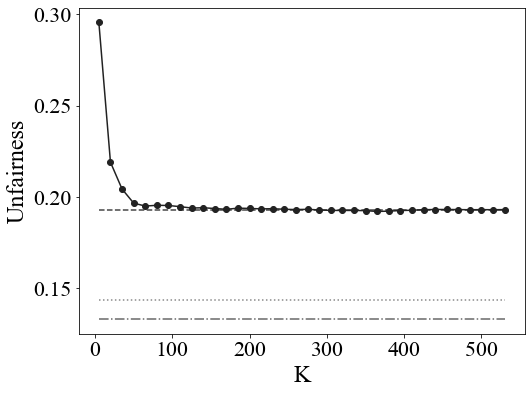

100%|██████████| 17/17 [00:01<00:00, 10.84it/s]


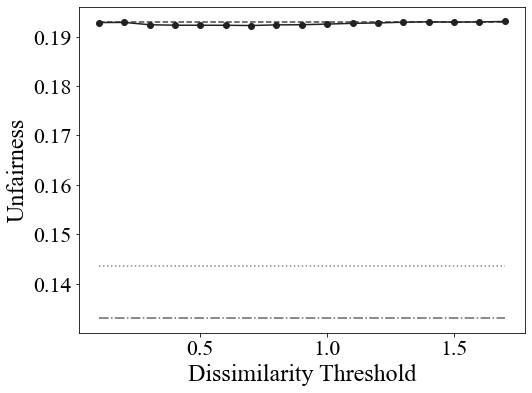

In [25]:
global_estimate_plot(
  df,
  distance_matrix,
  ks=np.arange(5, 531, 15),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
global_estimate_plot(
  df,
  distance_matrix,
  dists=np.arange(0.1, 1.8, 0.1),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


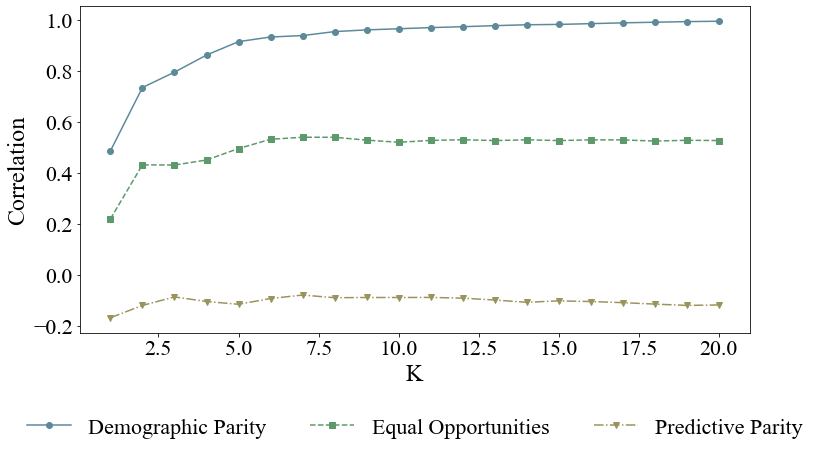

100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


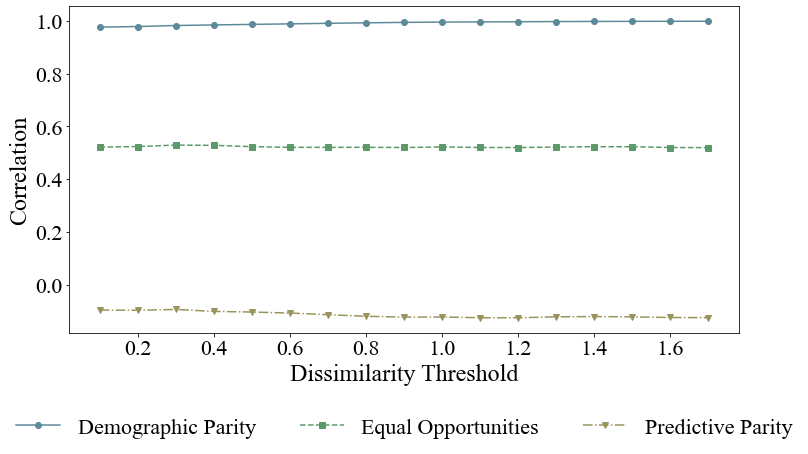

In [7]:
workers_estimate_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 21),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
workers_estimate_plot(
  df,
  distance_matrix,
  dists=np.arange(0.1, 1.8, 0.1),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

## Fairness mitigation

In [20]:
in_processing_stats(
  df,
  distance_matrix,
  ks=np.array([5, 100, 200, 300, 530]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
in_processing_stats(
  df,
  distance_matrix,
  dists=np.array([0.05, 0.3, 0.4, 0.5, 1.7]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                          5         100       200       300       530
Abs. Change                                                          
Demographic Parity  -0.119189 -0.188679 -0.162786 -0.176034 -0.192975
Equal Opportunities -0.054731 -0.112126 -0.021656  -0.11479 -0.133021
Predictive Parity    0.071068  0.076934  0.101287  0.053857  0.056108
Accuracy               -0.117    -0.158    -0.173    -0.197    -0.189

                            5          100        200        300        530
% Change                                                                   
Demographic  Parity  -61.764094 -97.774079 -84.356147 -91.221136     -100.0
Equal  Opportunities -41.144492 -84.291845 -16.280401 -86.294707     -100.0
Predictive  Parity    49.528108  53.615968  70.588359  37.533456  39.102577
Accuracy             -17.593985 -23.759398 -26.015038  -29.62406 -28.421053

                         0.05      0.30      0.40      0.50      1.70
Abs. Change                                         

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


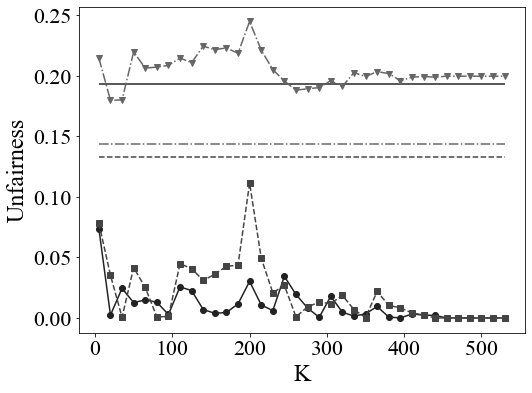

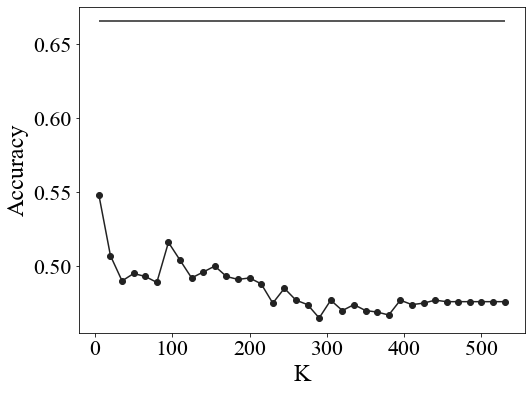

100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


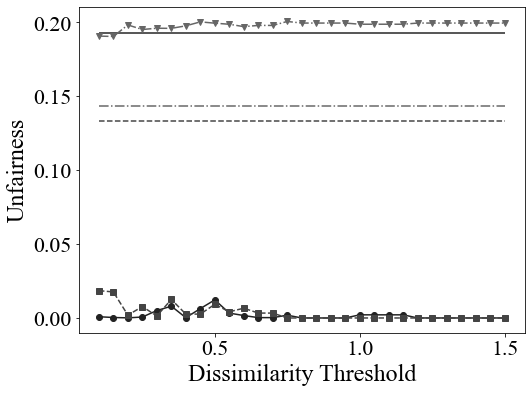

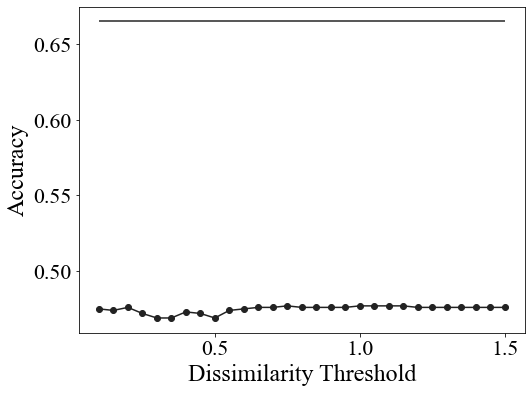

In [26]:
in_processing_plot(
  df,
  distance_matrix,
  ks=np.arange(5, 531, 15),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
in_processing_plot(
  df,
  distance_matrix,
  dists=np.arange(0.1, 1.55, 0.05),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

In [10]:
pre_processing_stats(
  df,
  distance_matrix,
  ks=np.arange(1, 21),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
pre_processing_stats(
  df,
  distance_matrix,
  dists=np.arange(0.1, 1.55, 0.05),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                           1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20
Abs. Change                                                                                                                                                                                                                
Demographic Parity  -0.047973 -0.094259  -0.11678 -0.111843 -0.091329 -0.164994 -0.180851 -0.172621 -0.141871 -0.158611 -0.169249 -0.154878 -0.181574 -0.167684 -0.188479  -0.16957 -0.176194 -0.176475 -0.184705 -0.189884
Equal Opportunities  0.006052 -0.056672 -0.014501 -0.071287 -0.055416 -0.117264 -0.101926  -0.11361  -0.10733 -0.108358 -0.115856  -0.09165 -0.115856 -0.105427 -0.080003 -0.111175 -0.102116 -0.090812 -0.093933 -0.093248
Predictive Parity     0.06037  0.049575   0.10434  0.050887  0.048406  0.065261  0.041215  0.044555  0.051397  0.024782 

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


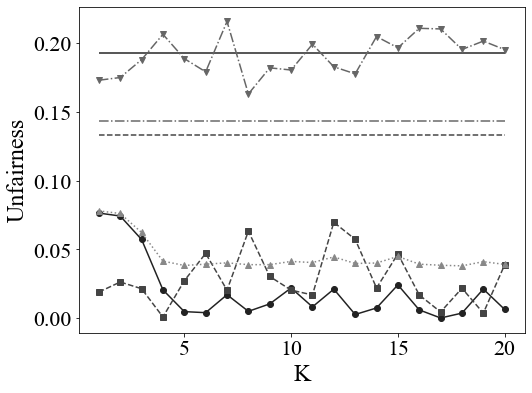

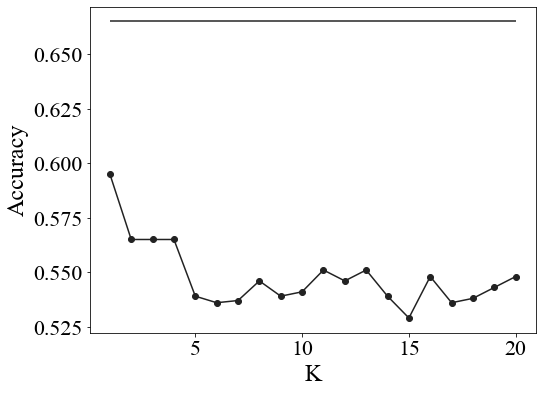

100%|██████████| 29/29 [00:45<00:00,  1.57s/it]


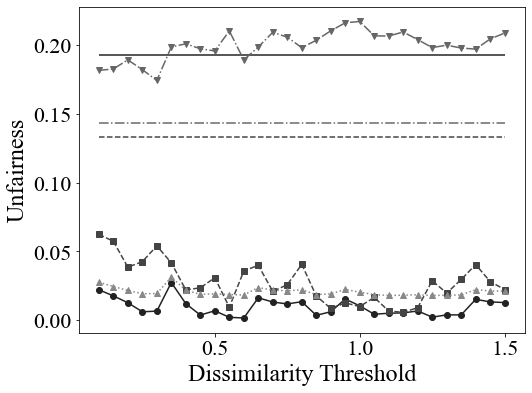

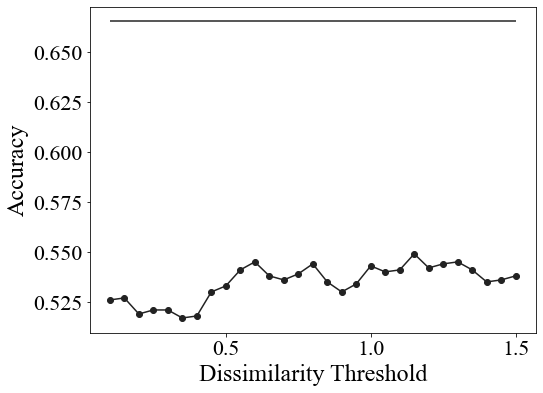

In [27]:
pre_processing_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 21),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
  estimation_k=150,
)
pre_processing_plot(
  df,
  distance_matrix,
  dists=np.arange(0.1, 1.55, 0.05),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
  estimation_dist=0.4,
)

## Downstream Tasks

In [11]:
downstream_tasks(
  df,
  [SimilarityPreProcessing(distance_matrix, k=15), MajorityVoting()],
  RandomForestClassifier(random_state=0),
  [DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                 Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Majority Voting            0.203372             0.145391           0.140729      0.67

               Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Fair Pipeline            0.123485              0.03258           0.155263     0.636



In [12]:
from faircrowd.mitigation import FairTD

downstream_tasks(
  df,
  [FairTD()],
  RandomForestClassifier(random_state=0),
  [DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                 Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Majority Voting            0.203372             0.145391           0.140729      0.67

               Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Fair Pipeline            0.100803             0.034445           0.174663     0.661



In [13]:
from faircrowd.mitigation import PreFairTD

downstream_tasks(
  df,
  [PreFairTD(), MajorityVoting()],
  RandomForestClassifier(random_state=0),
  [DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                 Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Majority Voting            0.203372             0.145391           0.140729      0.67

               Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Fair Pipeline            0.162385             0.124838           0.178734     0.617



In [14]:
from faircrowd.mitigation import PostFairTD

downstream_tasks(
  df,
  [MajorityVoting(), PostFairTD(random_state=0)],
  RandomForestClassifier(random_state=0),
  [DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                 Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Majority Voting            0.203372             0.145391           0.140729      0.67

               Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Fair Pipeline            0.109193             0.042057           0.159335     0.642



# Twitter Toxicity

In [33]:
df = load_jigsaw_toxicity()
display(df.describe())
df.head()

Answers: 5000 tasks and 6579 workers
Number of answers per worker:
     Mean          Std  Min  Median   Max
  19.7874  6150.907401    4     4.0  1685
1 Sensitive Features: s
10 Non-Sensitive Features: obscene, identity_attack, insult, threat, funny, wow, sad, likes, disagree, sexual_explicit
1 Response: result


,s,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,result
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.000000,5000.0,5000.000000,5000.000000
mean,0.102400,0.130800,0.023157,0.112872,0.011600,0.000800,0.000400,0.0,2.079800,0.0,0.008925,0.140200
std,0.303204,0.337215,0.077518,0.221521,0.057629,0.028276,0.019998,0.0,3.644021,0.0,0.052651,0.347229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.132710,0.000000,0.000000,0.000000,0.0,2.000000,0.0,0.000000,0.000000
max,1.000000,1.000000,0.825000,1.000000,0.917051,1.000000,1.000000,0.0,45.000000,0.0,0.920308,1.000000


,s,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,...,8742,8743,8744,8745,8757,8759,8762,8772,8773,result
59859,0,1,0.0000,0.333333,0.0000,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
239576,0,0,0.0000,0.000000,0.0000,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
239579,1,1,0.0000,0.320000,0.0000,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
239607,1,1,0.6125,0.887500,0.1125,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
239611,0,0,0.0000,0.000000,0.0000,0,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [34]:
import os

df.x.drop(columns=['likes', 'disagree'], inplace=True)
df.x[df.x.columns] = df.x.values > 0

X = df[['obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'sexual_explicit']]
X = X.values > 0
def jaccard(x, y):
  div = lambda x, y: x / y if y != 0 else 1
  idxs_x = np.argwhere(x).flatten()
  idxs_y = np.argwhere(y).flatten()
  return 1 - div(np.intersect1d(idxs_x, idxs_y).shape[0], np.union1d(idxs_x, idxs_y).shape[0])

if 'jt_distance_matrix.npy' in os.listdir('./'):
  distance_matrix = np.load('jt_distance_matrix.npy')
else:
  distance_matrix = distance_matrix = compute_distance_matrix(X, jaccard)
  np.save('jt_distance_matrix.npy', distance_matrix)

## Fairness estimation

In [17]:
global_estimate_stats(
  df,
  distance_matrix,
  ks=np.array([5, 100, 200, 300, 4468]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
print('\n')
global_estimate_stats(
  df,
  distance_matrix,
  dists=[0, 0.33, 0.5, 0.67, 1],
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:64: RuntimeWarning: divide by zero encountered in true_divide
  pct_diff.loc[metric] = (np.array(estimates) - true_value) / true_value * 100


            Demographic Parity  Equal Opportunities  Predictive Parity
True Value            0.054294             0.052973                0.0

                         5         100       200       300       4468
Abs. Change                                                          
Demographic Parity   0.024439 -0.005153   0.01166  0.069115  0.000267
Equal Opportunities   0.02576 -0.003832  0.012981  0.070436  0.001588
Predictive Parity    0.078733  0.049141  0.065954  0.123409  0.054562

                           5         100        200         300       4468
% Change                                                                  
Demographic  Parity   45.012714 -9.490723  21.474983  127.298093  0.492661
Equal  Opportunities  48.628617 -7.233868   24.50397  132.965787  2.998452
Predictive  Parity          inf       inf        inf         inf       inf



            Demographic Parity  Equal Opportunities  Predictive Parity
True Value            0.054294             0.052973      

/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:64: RuntimeWarning: divide by zero encountered in true_divide
  pct_diff.loc[metric] = (np.array(estimates) - true_value) / true_value * 100


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


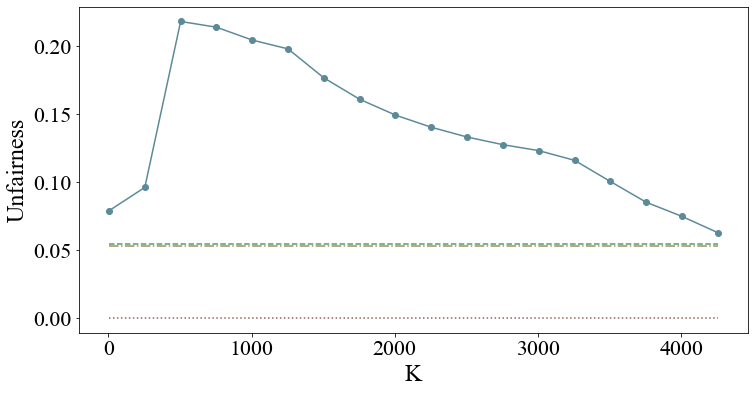

100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


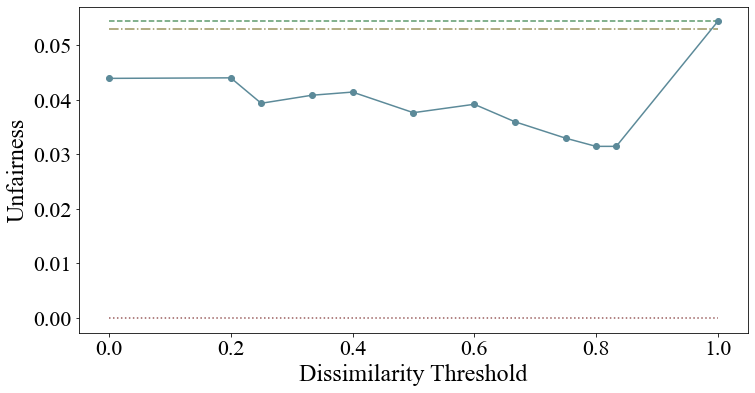

In [18]:
global_estimate_plot(
  df,
  distance_matrix,
  ks=np.arange(5, 4505, 250),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
global_estimate_plot(
  df,
  distance_matrix,
  dists=np.unique(distance_matrix.flatten()),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

/Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:50: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(fprs) - np.nanmin(fprs) if len(groups) > 1 else np.nan
/Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:75: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(ppvs) - np.nanmin(ppvs) if len(groups) > 1 else np.nan
100%|██████████| 25/25 [05:42<00:00, 13.70s/it]


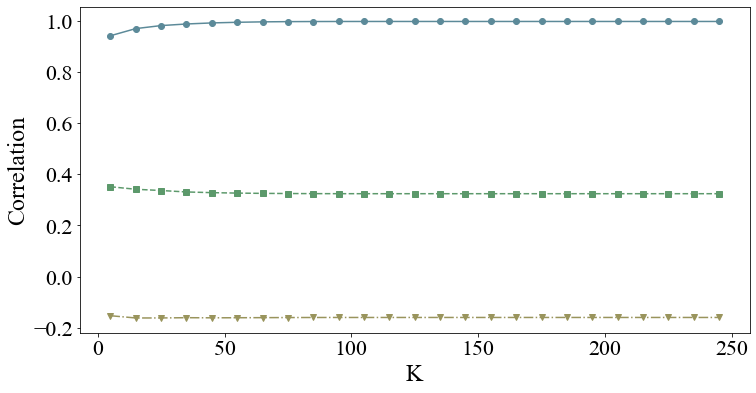

/Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:50: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(fprs) - np.nanmin(fprs) if len(groups) > 1 else np.nan
/Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:75: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(ppvs) - np.nanmin(ppvs) if len(groups) > 1 else np.nan
100%|██████████| 12/12 [03:26<00:00, 17.23s/it]


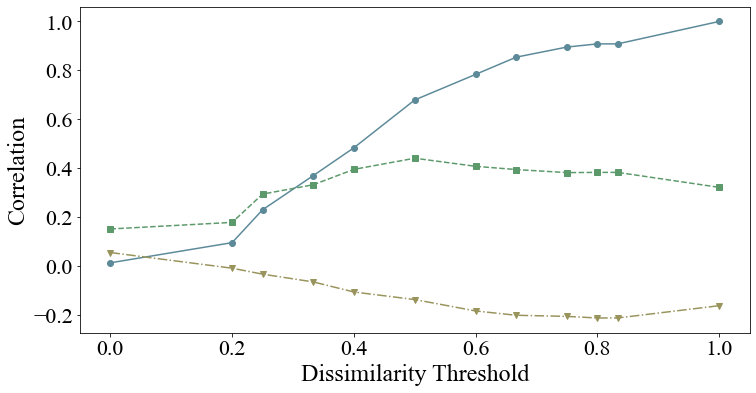

In [35]:
workers_estimate_plot(
  df,
  distance_matrix,
  ks=np.arange(5, 250, 10),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
workers_estimate_plot(
  df,
  distance_matrix,
  dists=np.unique(distance_matrix.flatten()),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

## Fairness mitigation

In [20]:
in_processing_stats(
  df,
  distance_matrix,
  ks=np.array([5, 100, 200, 300, 4468]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
in_processing_stats(
  df,
  distance_matrix,
  dists=[0, 0.33, 0.5, 0.67, 1],
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:75: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(ppvs) - np.nanmin(ppvs) if len(groups) > 1 else np.nan


                         5         100       200       300       4468
Abs. Change                                                          
Demographic Parity  -0.004756  0.056856   0.03705  0.185491 -0.054294
Equal Opportunities  0.080885  0.004832  0.033243 -0.009358 -0.052973
Predictive Parity     0.03478  0.071373   0.05162  0.134701       NaN
Accuracy              -0.0638   -0.0954   -0.0996   -0.1116    -0.129

                            5           100        200         300        4468
% Change                                                                      
Demographic  Parity    -8.759218  104.719461   68.23982  341.641552     -100.0
Equal  Opportunities  152.690787    9.121313  62.754637  -17.664944     -100.0
Predictive  Parity           inf         inf        inf         inf        NaN
Accuracy               -6.452265   -9.648058 -10.072816  -11.286408 -13.046117



/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (
/Users/simone/Work/fair-crowd/faircrowd/utils/similarity.py:220: RuntimeWarning: divide by zero encountered in double_scalars
  (


                         0.00      0.33      0.50      0.67      1.00
Abs. Change                                                          
Demographic Parity   0.054729  0.056185  0.055387    0.1803 -0.054294
Equal Opportunities -0.025754 -0.030344 -0.009809 -0.012708 -0.052973
Predictive Parity    0.108677   0.10303  0.074315  0.132943       NaN
Accuracy              -0.0702   -0.0712   -0.0858   -0.1096    -0.129

                            0.00        0.33        0.50        0.67       1.00
% Change                                                                       
Demographic  Parity   100.801539  103.481885  102.013466  332.080795     -100.0
Equal  Opportunities  -48.616601  -57.281849  -18.516266  -23.989054     -100.0
Predictive  Parity           inf         inf         inf         inf        NaN
Accuracy               -7.099515   -7.200647   -8.677184  -11.084142 -13.046117



/Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:75: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(ppvs) - np.nanmin(ppvs) if len(groups) > 1 else np.nan


100%|██████████| 21/21 [07:28<00:00, 21.38s/it]


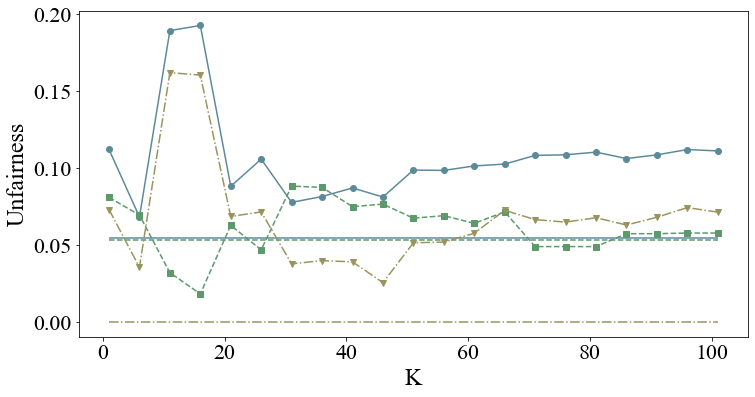

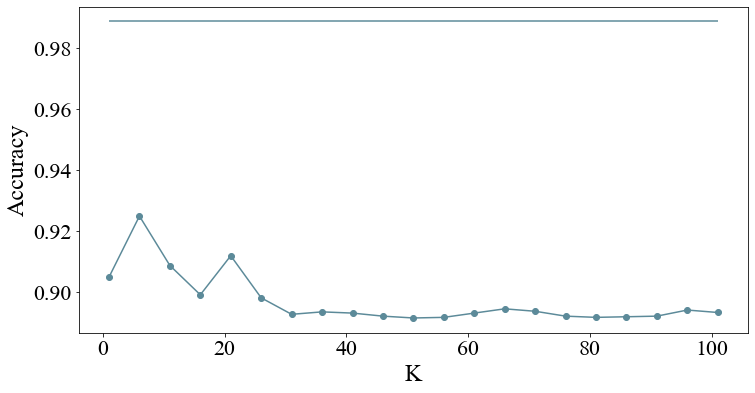

 92%|█████████▏| 11/12 [2:20:32<13:35, 815.71s/it] /Users/simone/Work/fair-crowd/faircrowd/metrics/fairness.py:75: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(ppvs) - np.nanmin(ppvs) if len(groups) > 1 else np.nan
100%|██████████| 12/12 [2:48:11<00:00, 840.98s/it] 


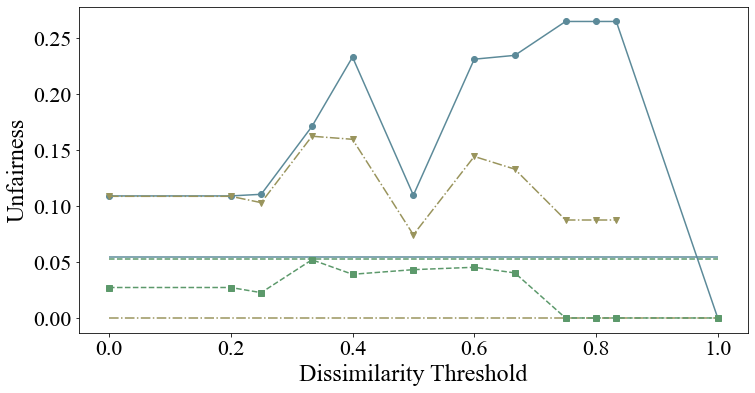

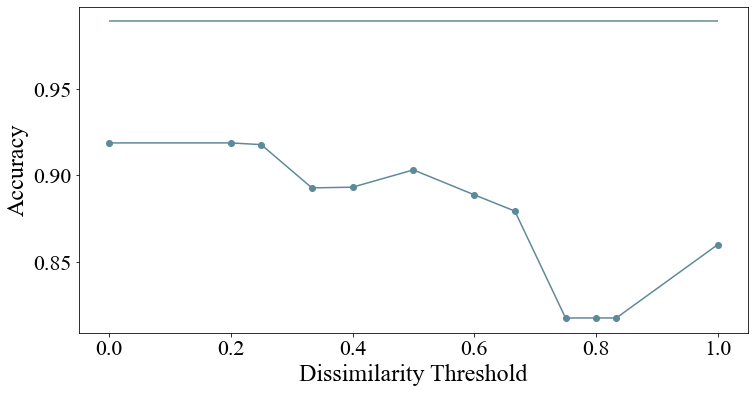

In [21]:
in_processing_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 102, 5),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
in_processing_plot(
  df,
  distance_matrix,
  dists=np.unique(distance_matrix.flatten()),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

100%|██████████| 21/21 [02:18<00:00,  6.61s/it]


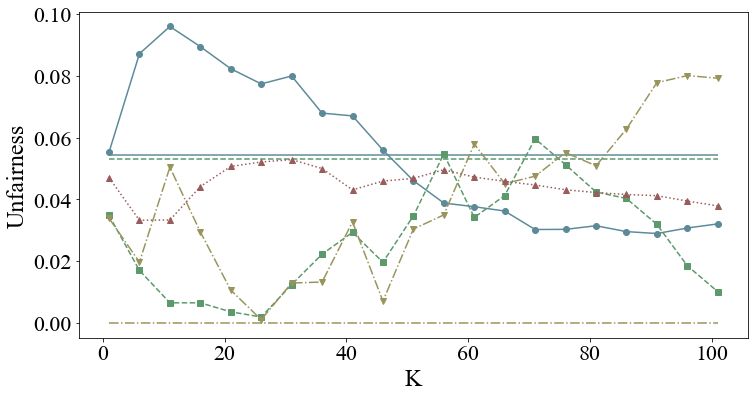

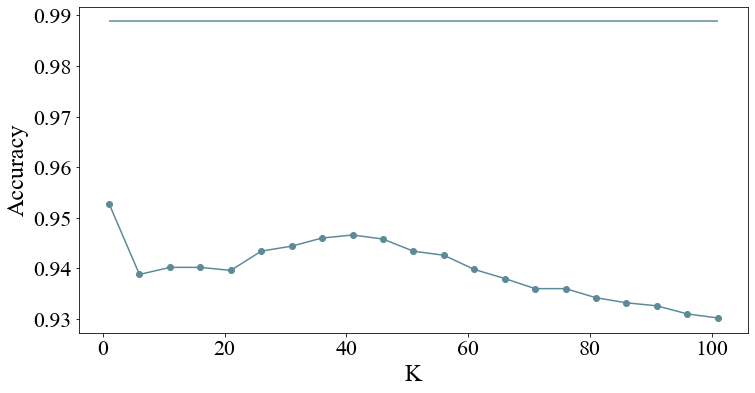

100%|██████████| 12/12 [01:41<00:00,  8.47s/it]


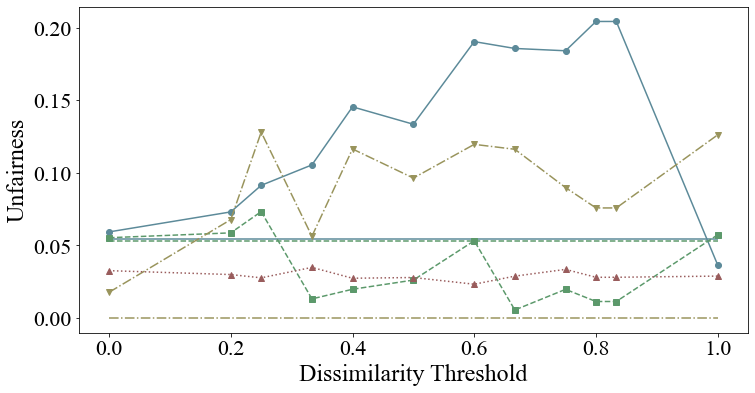

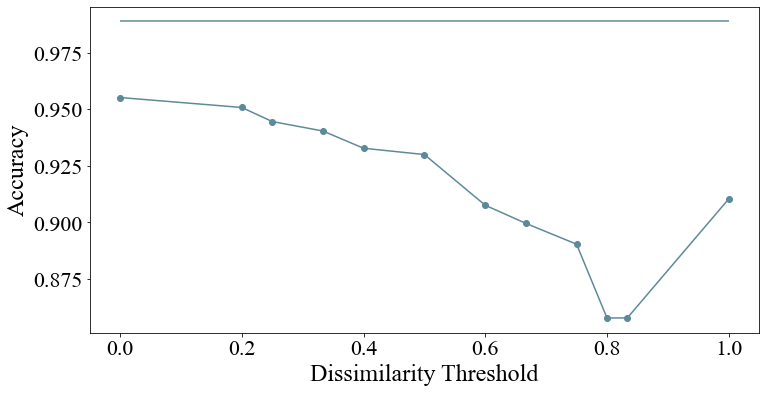

In [22]:
# n_steps = 100
pre_processing_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 102, 5), # np.linspace(1 / n_steps, 1, n_steps)
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
  estimation_dist=0,
)
pre_processing_plot(
  df,
  distance_matrix,
  dists=np.unique(distance_matrix.flatten()),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
  estimation_dist=0,
)

## Downstream Tasks

In [23]:
downstream_tasks(
  df,
  [SimilarityPreProcessing(distance_matrix, dist=0), MajorityVoting()],
  RandomForestClassifier(random_state=0),
  [DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                 Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Majority Voting            0.116241             0.108588           0.144793     0.916

               Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Fair Pipeline            0.085297             0.061461            0.08909    0.9186



# Synthetic

In [2]:
df = load_synthetic()
display(df.describe())
df.head()

Answers: 5000 tasks and 500 workers
Number of answers per worker:
  Mean  Std  Min  Median  Max
  10.0  0.0   10    10.0   10
1 Sensitive Features: s
1 Non-Sensitive Features: x
1 Response: result


,s,x,result
count,5000.00000,5000.000000,5000.000000
mean,0.50020,-0.014726,0.544600
std,0.50005,0.985435,0.498057
min,0.00000,-3.740101,0.000000
25%,0.00000,-0.692365,0.000000
50%,1.00000,-0.021891,1.000000
75%,1.00000,0.650053,1.000000
max,1.00000,3.801660,1.000000


,s,x,0,1,2,3,4,5,6,7,...,491,492,493,494,495,496,497,498,499,result
0,1,1.764052,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0,0.400157,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0,0.978738,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,2.240893,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0,1.867558,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
X = df['x'].values
distance_matrix = compute_distance_matrix(X, lambda x, y: np.linalg.norm(x - y))

100%|██████████| 12497500/12497500 [01:00<00:00, 207105.32it/s]


## Fairness estimation

In [38]:
global_estimate_stats(
  df,
  distance_matrix,
  ks=np.array([5, 100, 200, 300, 2500]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
print('\n')
global_estimate_stats(
  df,
  distance_matrix,
  dists=[0.05, 0.5, 1, 1.5, 3],
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

            Demographic Parity  Equal Opportunities  Predictive Parity
True Value            0.001649             0.243987           0.086139

                         5         100       200       300       2500
Abs. Change                                                          
Demographic Parity   0.231178  0.132834  0.131233  0.129386  0.000088
Equal Opportunities  -0.01116 -0.109504 -0.111105 -0.112951  -0.24225
Predictive Parity    0.146688  0.048344  0.046743  0.044897 -0.084402

                              5            100          200          300        2500
% Change                                                                            
Demographic  Parity   14018.234538  8054.840594  7957.750724  7845.767262   5.327064
Equal  Opportunities     -4.574042   -44.880964     -45.5372   -46.294103 -99.288088
Predictive  Parity      170.292954     56.12405    54.265269    52.121351 -97.983518



            Demographic Parity  Equal Opportunities  Predictive Parity
True Va

100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


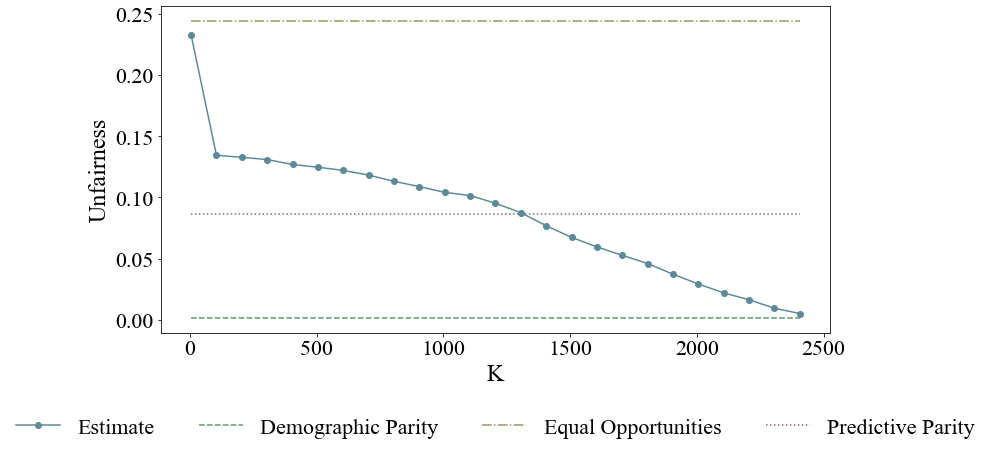

100%|██████████| 31/31 [00:21<00:00,  1.42it/s]


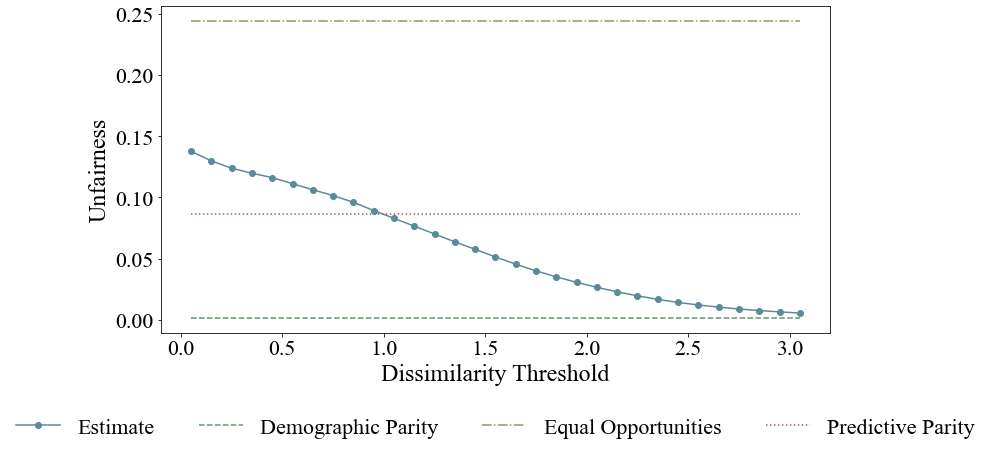

In [39]:
global_estimate_plot(
  df,
  distance_matrix,
  ks=np.arange(5, 2500, 100),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
global_estimate_plot(
  df,
  distance_matrix,
  dists=np.arange(0.05, 3.1, 0.1),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

100%|██████████| 30/30 [01:18<00:00,  2.61s/it]


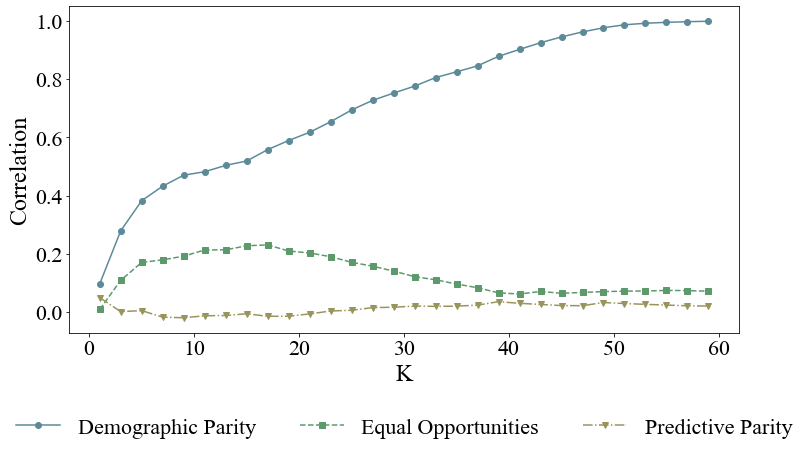

100%|██████████| 31/31 [02:03<00:00,  3.97s/it]


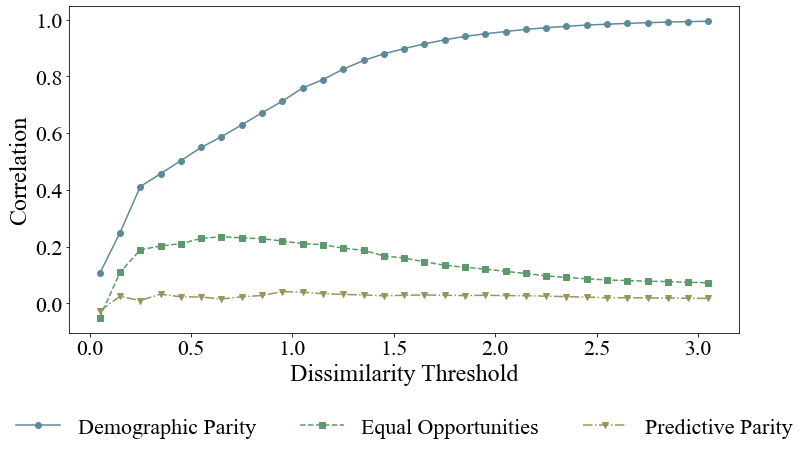

In [40]:
workers_estimate_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 61, 2),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
workers_estimate_plot(
  df,
  distance_matrix,
  dists=np.arange(0.05, 3.1, 0.1),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

## Fairness mitigation

In [41]:
in_processing_stats(
  df,
  distance_matrix,
  ks=np.array([5, 100, 200, 300, 2500]),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
in_processing_stats(
  df,
  distance_matrix,
  dists=[0.05, 0.5, 1, 1.5, 3],
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                         5         100       200       300       2500
Abs. Change                                                          
Demographic Parity   0.026358  0.016751  0.017151  0.016752 -0.001649
Equal Opportunities -0.160673 -0.173115 -0.181044  -0.18057 -0.243987
Predictive Parity   -0.018357  0.012393  0.020386  0.020519  0.045826
Accuracy                0.008    0.0072    0.0078     0.008    -0.253

                             5            100          200          300        2500
% Change                                                                           
Demographic  Parity   1598.292423  1015.756282  1039.982536  1015.795091     -100.0
Equal  Opportunities   -65.852991   -70.952735   -74.202351   -74.008227     -100.0
Predictive  Parity     -21.310575    14.387176    23.666644     23.82037  53.199941
Accuracy                 1.003009     0.902708     0.977934     1.003009  -31.72016

                         0.05      0.50      1.00      1.50      3.00
Abs.

100%|██████████| 21/21 [01:13<00:00,  3.49s/it]


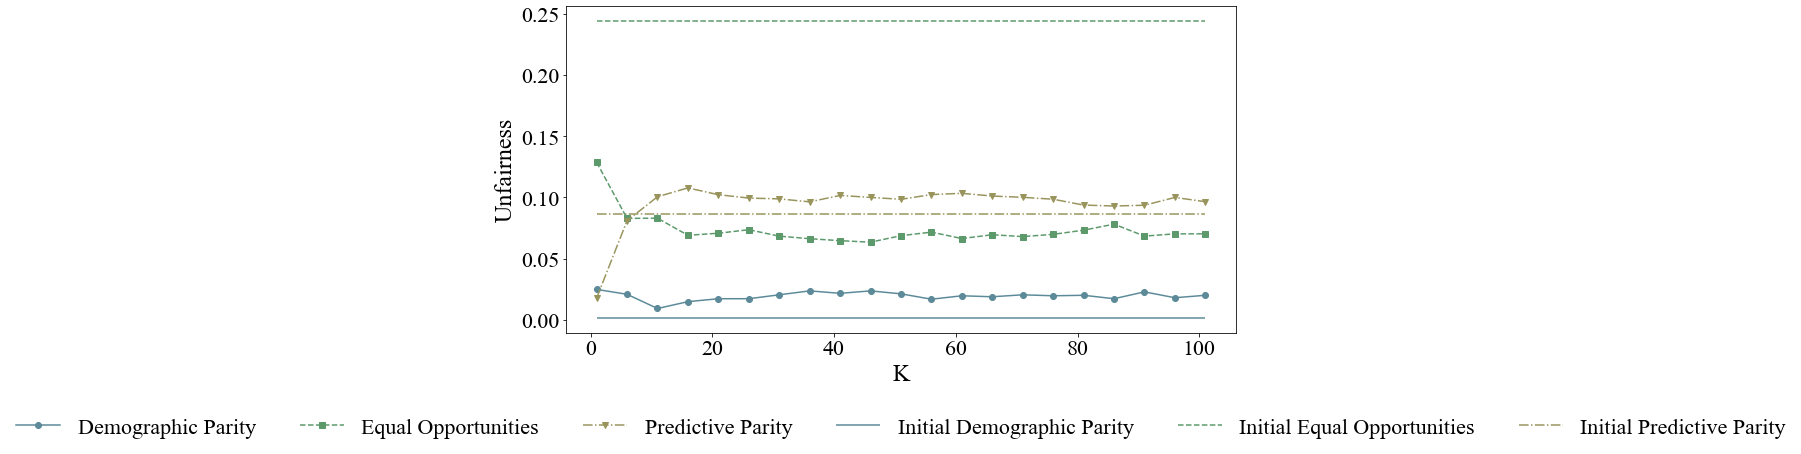

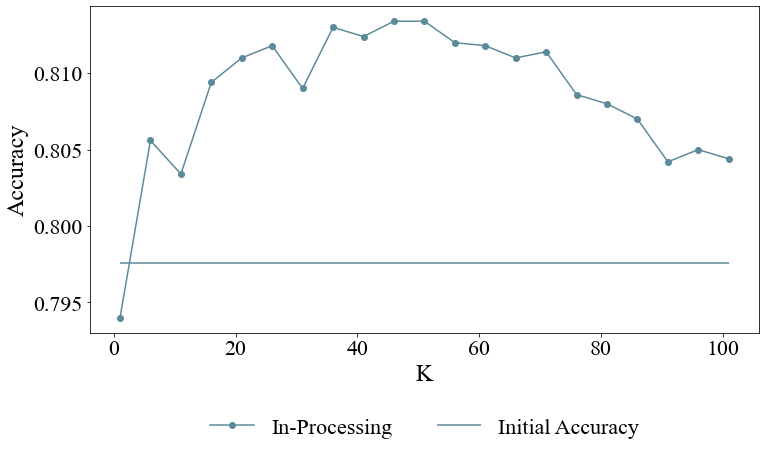

100%|██████████| 31/31 [14:12<00:00, 27.49s/it]


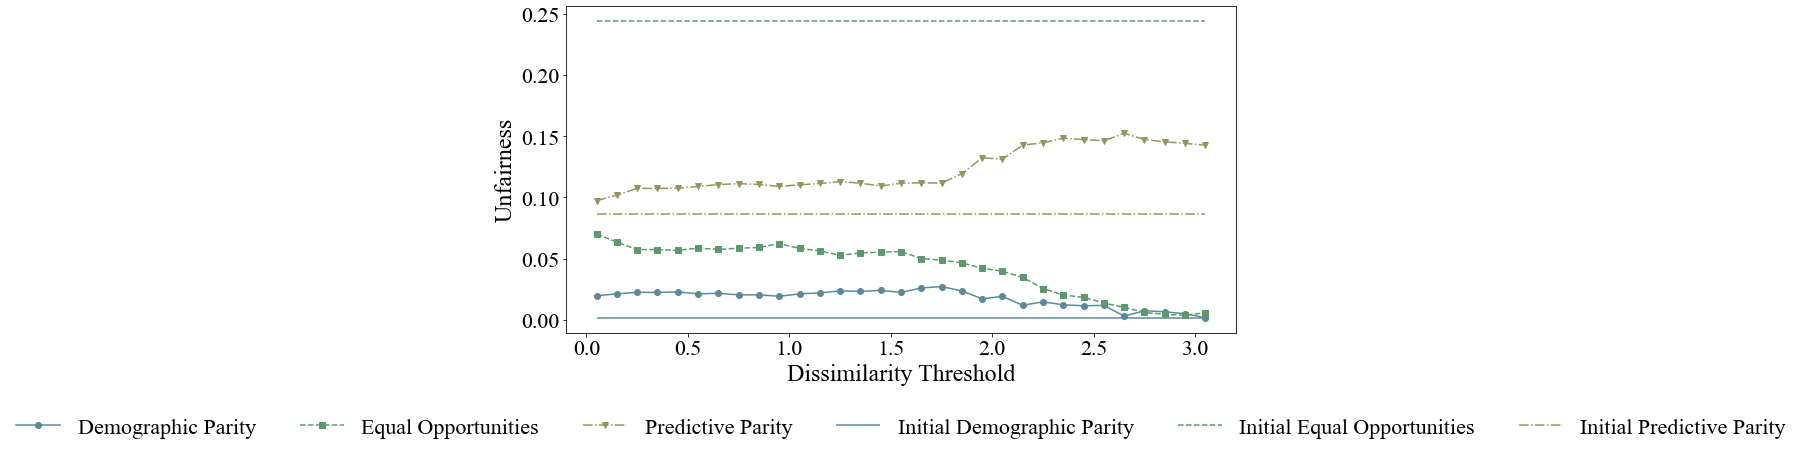

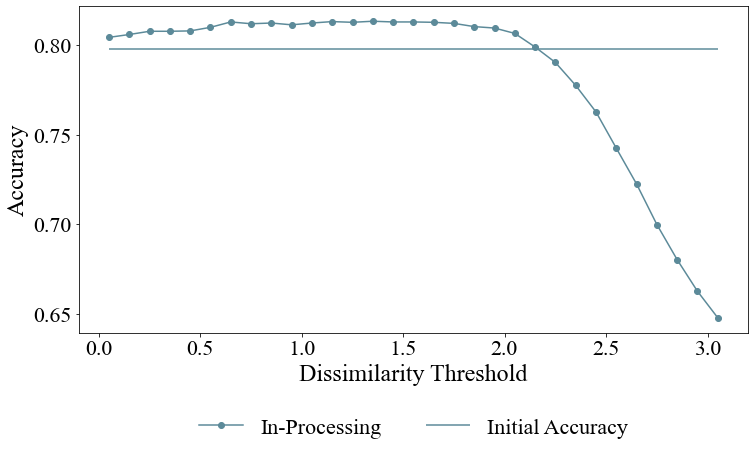

In [42]:
in_processing_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 102, 5),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)
in_processing_plot(
  df,
  distance_matrix,
  dists=np.arange(0.05, 3.1, 0.1),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

100%|██████████| 30/30 [02:28<00:00,  4.96s/it]


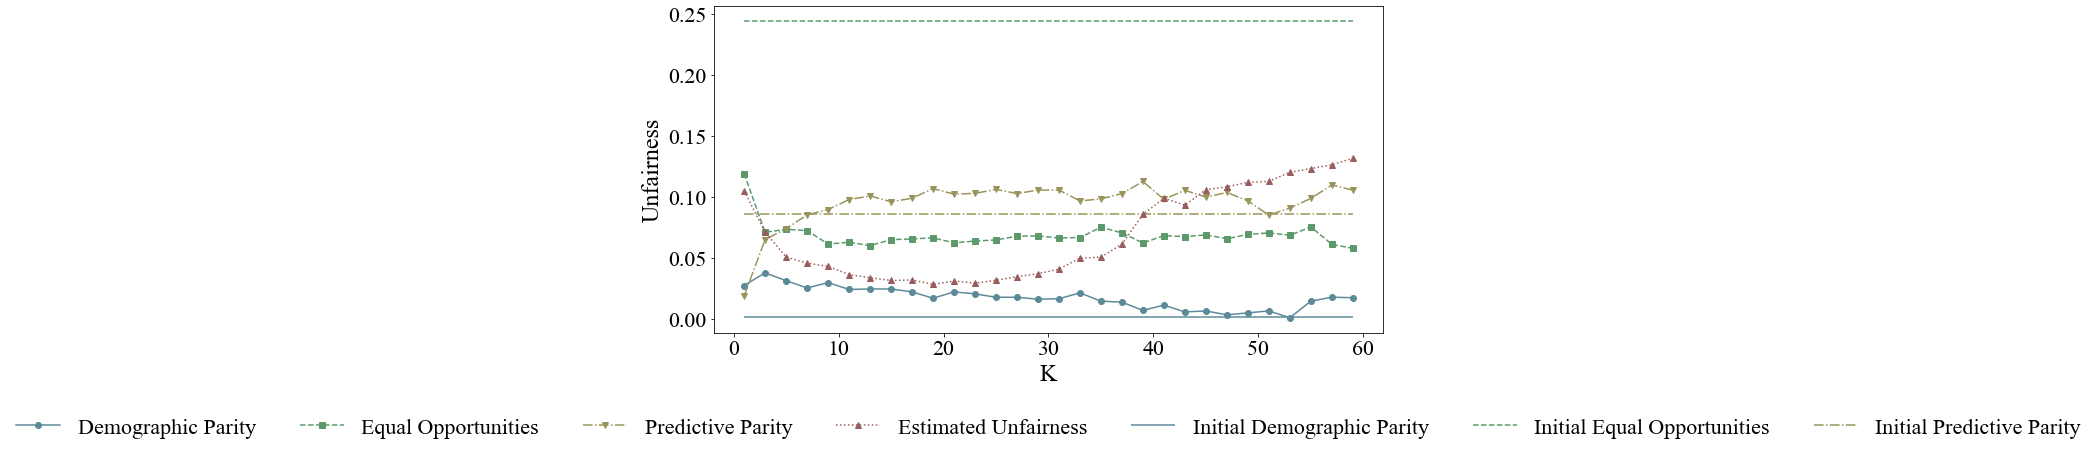

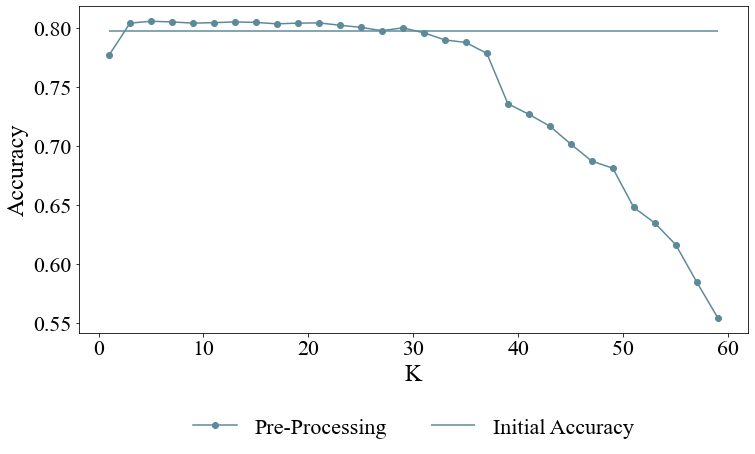

100%|██████████| 31/31 [02:25<00:00,  4.69s/it]


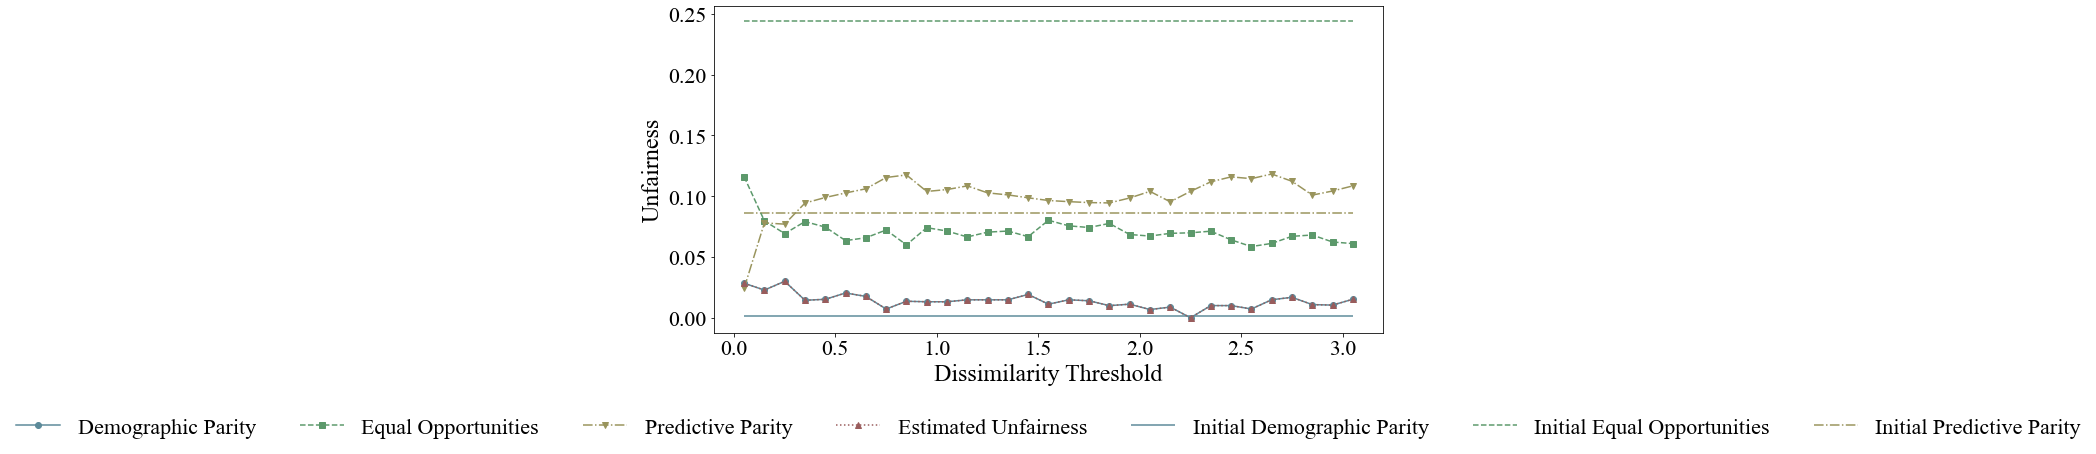

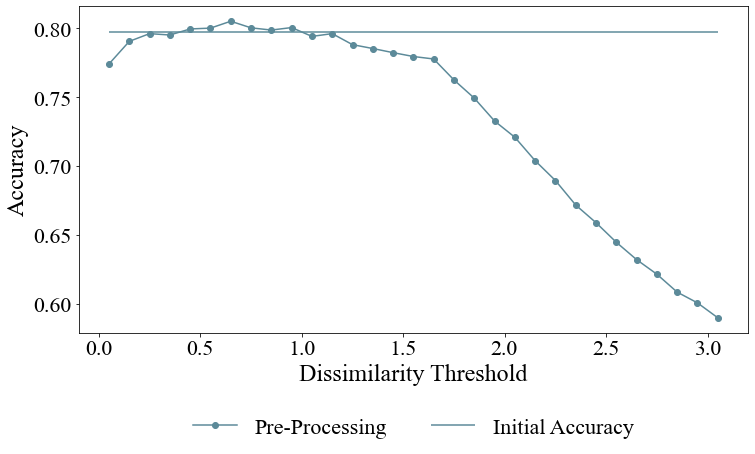

In [4]:
# n_steps = 100
pre_processing_plot(
  df,
  distance_matrix,
  ks=np.arange(1, 61, 2), # np.linspace(1 / n_steps, 1, n_steps)
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
  estimation_k=20,
)
pre_processing_plot(
  df,
  distance_matrix,
  dists=np.arange(0.05, 3.1, 0.1),
  metrics=[DemographicParity(), EqualOpportunities(), PredictiveParity()],
  estimation_dist=20,
)

## Downstream tasks

In [44]:
downstream_tasks(
  df,
  [SimilarityPreProcessing(distance_matrix, k=25), MajorityVoting()],
  RandomForestClassifier(random_state=0),
  [DemographicParity(), EqualOpportunities(), PredictiveParity()],
)

                 Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Majority Voting            0.002449             0.243151           0.086848    0.7972

               Demographic Parity  Equal Opportunities  Predictive Parity  Accuracy
Fair Pipeline            0.018795             0.063124           0.105672    0.8006

